In [47]:
!pip install -r requirements.txt

In [38]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matlab.engine
from cycler import cycler
from scipy.optimize import curve_fit

%matplotlib inline

plt.style.use("default")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=14)
plt.rc('grid', color='gray')
plt.rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('text.latex',preamble=r'\usepackage[russian]{babel}')

eng = matlab.engine.start_matlab()
colors = eng.eval("get(gca,'colororder')", nargout=1)
cols = []
for x in zip(np.array(colors)):
    cols.append((x[0][0], x[0][1], x[0][2]))
mpl.rcParams['axes.prop_cycle'] = cycler('color', cols)

data_folder: str = "data"
vs = np.array(list(filter(lambda x: x != 0, np.arange(-100, 100 + 1, 20))))

In [39]:
def pname(i: int, j: int, prefix: str = "", format: str = "svg"):
    return f"report/images/{prefix}-{i}.{j}.{format}"


def process_file(v: int, datapath: str = "data") -> pd.DataFrame: 
    data = pd.read_csv(f"{datapath}/data{v}.csv", delimiter=' ', names=['t', 'ang', 'w'])
    data['ang'] = np.deg2rad(data['ang'])
    if v > 0:
        data['ang'] = data['ang'] - data['ang'].min()
    elif v < 0:
        data['ang'] = data['ang'] - data['ang'].max()
    data['w'] = np.deg2rad(data['w'])
    return data


def fit(f, data: pd.DataFrame, prop: str):
    x = data.t
    y = data[prop]
    popt, _ = curve_fit(f, x, y)
    return popt

In [40]:
data = [process_file(v) for v in vs]

theta = lambda t, k, T_m: k * v * (t - T_m * (1 - np.exp(-t / T_m)))
omega = lambda t, k, T_m: k * v * (1 - np.exp(-t / T_m))

# Построение экспериментальных графиков

In [41]:
for i, d, v in zip(range(1, len(vs) + 1), data, vs):
    plt.plot(d.t, d.ang, label=r"$\theta_{exp}$")

    plt.grid(alpha=0.15)
    plt.xlabel(r"$t,\ s$")
    plt.ylabel(r"$\theta,\ rad$")
    plt.title(rf"$V = {v}\%$")
    plt.xlim(left=0)
    plt.savefig(f"report/images/ang{v}-plot-exp.png", dpi=500)
    plt.clf()

    plt.plot(d.t, d.w, label=r'$\omega_{exp}$')


    plt.grid(alpha=0.15)
    plt.xlabel(r"$t,\ s$")
    plt.ylabel(r"$\omega,\ rad/s$")
    plt.title(rf"$V = {v}\%$")
    plt.xlim(left=0)
    plt.savefig(f"report/images/w{v}-plot-exp.png", dpi=500)
    plt.clf()

<Figure size 640x480 with 0 Axes>

# Построение графиков с апрроксимацией

In [43]:
ks_ang, ks_w, Tms_ang, Tms_w = [[] for _ in range(4)]
for d, v in zip(data, vs):
    # approximate theta
    k_ang, Tm_ang = fit(theta, d, "ang")
    ks_ang.append(k_ang)
    Tms_ang.append(Tm_ang)
    
    # approximate w
    k_w, Tm_w = fit(omega, d, "w")
    ks_w.append(k_w)
    Tms_w.append(Tm_w)
    
# params for simulink modelling
model_k = np.mean(ks_ang)
model_Tm = np.mean(Tms_ang)

for i, d, v in zip(range(len(vs)), data, vs):
    # plot experimental data
    plt.plot(d.t, d.ang, label=r"$\theta_{exp}$")

    # plot approximation
    x_apr = np.linspace(0, 1, 1000)
    plt.plot(
        x_apr,
        theta(x_apr, ks_ang[i], Tms_ang[i]),
        label=r"$\theta_{approx}$",
        linestyle="--",
        c='r'
    )
    

    plt.grid(alpha=0.15)
    plt.xlabel(r"$t,\ s$")
    plt.ylabel(r"$\theta,\ rad$")
    plt.title(rf"$V = {v}\%$")
    plt.xlim(left=0)
    plt.legend()
    plt.savefig(f"report/images/ang{v}-plot-approx.png", dpi=500)
    plt.clf()

    plt.plot(d.t, d.w, label=r'$\omega_{exp}$')
    
    plt.plot(
        x_apr,
        omega(x_apr, ks_w[i], Tms_w[i]),
        label=r"$\omega_{approx}$",
        linestyle="--",
        c='r'
    )


    plt.grid(alpha=0.15)
    plt.xlabel(r"$t,\ s$")
    plt.ylabel(r"$\omega,\ rad/s$")
    plt.title(rf"$V = {v}\%$")
    plt.xlim(left=0)
    plt.legend()
    plt.savefig(f"report/images/w{v}-plot-approx.png", dpi=500)
    plt.clf()

<Figure size 640x480 with 0 Axes>

# Построение финальных графиков

In [44]:
for i, d, v in zip(range(len(vs)), data, vs):
    # plot experimental theta
    plt.plot(d.t, d.ang, label=r"$\theta_{exp}$")

    # plot approximation theta
    x_apr = np.linspace(0, 1, 1000)
    plt.plot(
        x_apr,
        theta(x_apr, ks_ang[i], Tms_ang[i]),
        label=r"$\theta_{approx}$",
        linestyle="--",
        c='r'
    )
    
    # modelling
    eng.workspace["U_pr"] = v
    eng.workspace["k"] = model_k
    eng.workspace["T_m"] = model_Tm
    eng.eval(f"out = sim('model.slx', 'StopTime', '1', 'FixedStep', '0.001');", nargout=0)
    thout = np.array(eng.eval("out.theta.data", nargout=1))
    tout = np.array(eng.eval("out.theta.time", nargout=1))
    wout = np.array(eng.eval("out.omega.data", nargout=1))
    
    # plot model theta
    plt.plot(tout, thout, label=r'$\theta_{model}$', linestyle='-.', c='g')

    # style and save theta plot
    plt.grid(alpha=0.15)
    plt.xlabel(r"$t,\ s$")
    plt.ylabel(r"$\theta,\ rad$")
    plt.title(rf"$V = {v}\%$")
    plt.xlim(left=0)
    plt.legend()
    plt.savefig(f"report/images/ang{v}-plot-fin.png", dpi=500)
    plt.show()
    plt.clf()

    # plot exprimental omega
    plt.plot(d.t, d.w, label=r'$\omega_{exp}$')
    
    # plot approximation omega
    plt.plot(
        x_apr,
        omega(x_apr, ks_w[i], Tms_w[i]),
        label=r"$\omega_{approx}$",
        linestyle="--",
        c='r'
    )
    
    # plot model omega
    plt.plot(tout, wout, label=r'$\omega_{model}$', linestyle='-.', c='g')

    # style and save omega plot
    plt.grid(alpha=0.15)
    plt.xlabel(r"$t,\ s$")
    plt.ylabel(r"$\omega,\ rad/s$")
    plt.title(rf"$V = {v}\%$")
    plt.xlim(left=0)
    plt.legend()
    plt.savefig(f"report/images/w{v}-plot-fin.png", dpi=500)
    plt.show()
    plt.clf()


<Figure size 640x480 with 0 Axes>

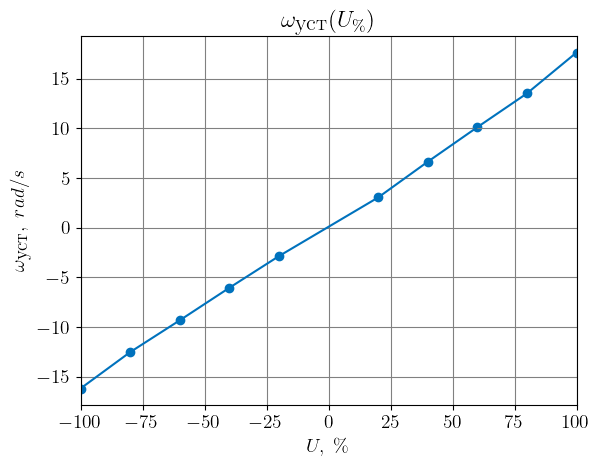

In [45]:
w_nls = [v * k for v, k in zip(vs, ks_w)]
plt.title(r"$\omega_{\textrm{уст}}(U_{\%})$")
plt.plot(vs, w_nls)
plt.grid()
plt.xlim((-100,100))
plt.xlabel(r"$U,\ \%$")
plt.ylabel(r"$\omega_{\textrm{уст}},\ rad/s$")
plt.scatter(vs,w_nls)
plt.savefig("report/images/w-u-plot.png",dpi=500)

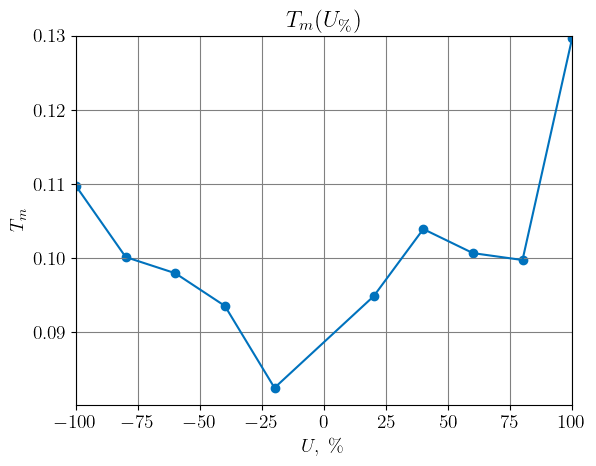

In [37]:
plt.title(r"$T_m(U_{\%})$")
plt.plot(vs, Tms_w)
plt.scatter(vs,Tms_w)
plt.grid()
plt.xlim((-100,100))
plt.ylim(top=0.13)
plt.xlabel(r"$U,\ \%$")
plt.ylabel(r"$T_m$")
plt.savefig("report/images/Tm-u-plot.png",dpi=500)